In [2]:
import sys
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np
import netCDF4 as nc

# geo tools
from scipy.interpolate import griddata
from cartopy.io.shapereader import Reader

# deep learning tools
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu
import model_utils as mu
import train_utils as tu

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
camp_t2 = gu.cmap_combine(plt.cm.viridis, plt.cm.plasma_r)

In [4]:
with h5py.File(JRA_dir+'JRA_TMEAN_features_US_2015_2020.hdf', 'r') as hdf_io:
    lon_4km = hdf_io['lon_4km'][...]
    lat_4km = hdf_io['lat_4km'][...]
    TMEAN_4km = hdf_io['TMEAN_4km'][...]
    ERA_REGRID = hdf_io['TMEAN_REGRID'][...]

with h5py.File(PRISM_dir+'PRISM_TMEAN_features_2015_2020.hdf', 'r') as hdf_io:
    lon_025 = hdf_io['lon_025'][...]
    lat_025 = hdf_io['lat_025'][...]
    TMEAN_REGRID = hdf_io['TMEAN_REGRID'][...]

In [21]:
with h5py.File(ERA_dir+'ERA_TMEAN_features_2015_2020.hdf', 'r') as hdf_io:
    TMEAN_REGRID = hdf_io['TMEAN_REGRID'][...]

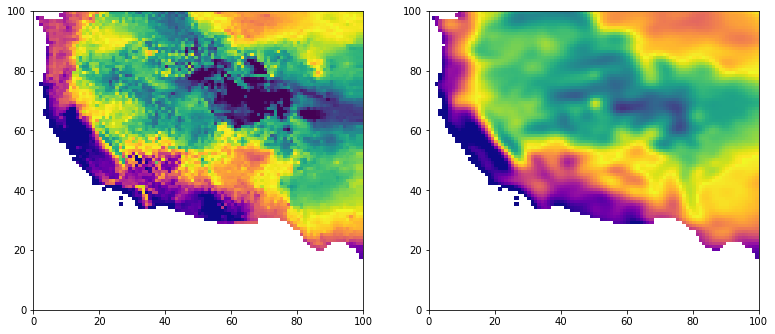

In [5]:
fig, AX = plt.subplots(1, 2, figsize=(13, 5.5))
AX[0].pcolormesh(TMEAN_REGRID[0, ::6, ::6], vmin=-20, vmax=5, cmap=camp_t2)
AX[1].pcolormesh(ERA_REGRID[0, ::6, ::6], vmin=-20, vmax=5, cmap=camp_t2)

In [30]:
with h5py.File(save_dir+'ERA_PRED_TMEAN_2018_2020.hdf', 'r') as hdf_io:
    ERA_UNET = hdf_io['RESULT_UNET'][...]
    
with h5py.File(save_dir+'JRA_PRED_TMEAN_2018_2020.hdf', 'r') as hdf_io:
    JRA_UNET = hdf_io['RESULT_UNET'][...]

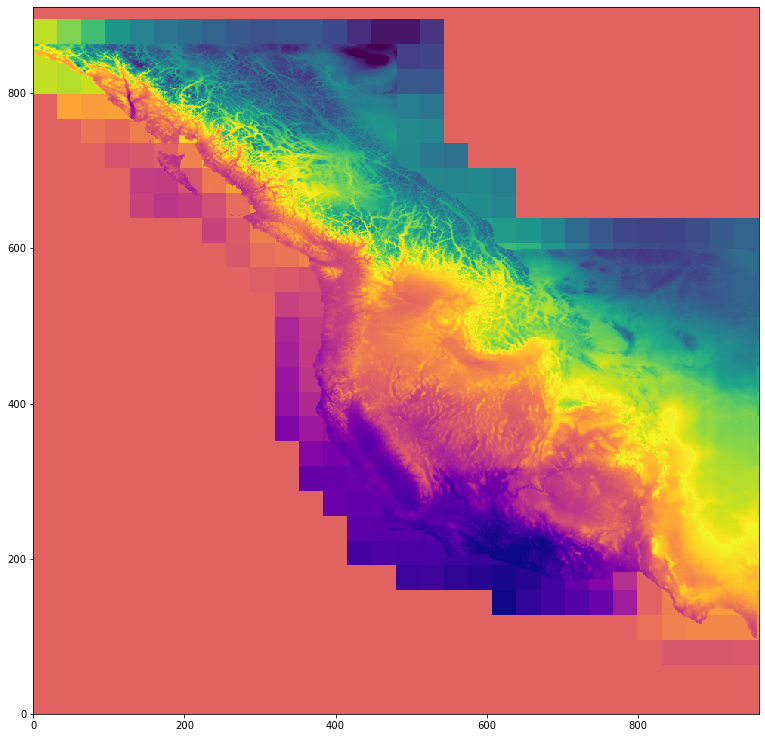

In [40]:
fig = plt.figure(figsize=(13, 13))
plt.pcolormesh(ERA_UNET[0, ...], vmin=-35, vmax=15, cmap=camp_t2)

In [27]:
with h5py.File(JRA_dir + 'JRA_TMEAN_GAMMA_2018_2020.hdf', 'r') as hdf_io:
    lon_025 = hdf_io['lon_025'][...]
    lat_025 = hdf_io['lat_025'][...]
    jra_gamma = hdf_io['jra_gamma'][...]

(array([ 186.,  710., 1636., 1847., 1164.,  817.,  101.,   37.,   20.,
          48.]),
 array([-7.96509094, -7.26953952, -6.57398809, -5.87843667, -5.18288525,
        -4.48733383, -3.79178241, -3.09623098, -2.40067956, -1.70512814,
        -1.00957672]),
 <a list of 10 Patch objects>)

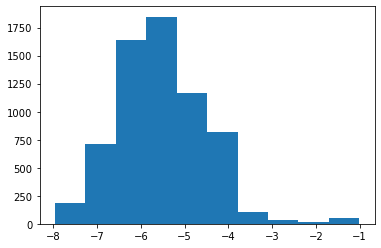

In [43]:
plt.hist(1000*jra_gamma[0, ...].ravel())

In [10]:
with nc.Dataset(JRA_TMEAN_dir+'anl_surf.011_tmp.reg_tl319.2015010100_2015013118.sha410426.nc', 'r') as nc_io:
    x025 = nc_io['g4_lon_2'][...]-360 # <--- fix to [-180, 180]
    y025 = nc_io['g4_lat_1'][...]
lon_025, lat_025 = np.meshgrid(x025, y025)

In [44]:
with h5py.File(ERA_dir+'ERA_TMEAN_clean_2018.hdf', 'r') as hdf_io:
    REGRID_2018 = hdf_io['TMEAN_025'][...]

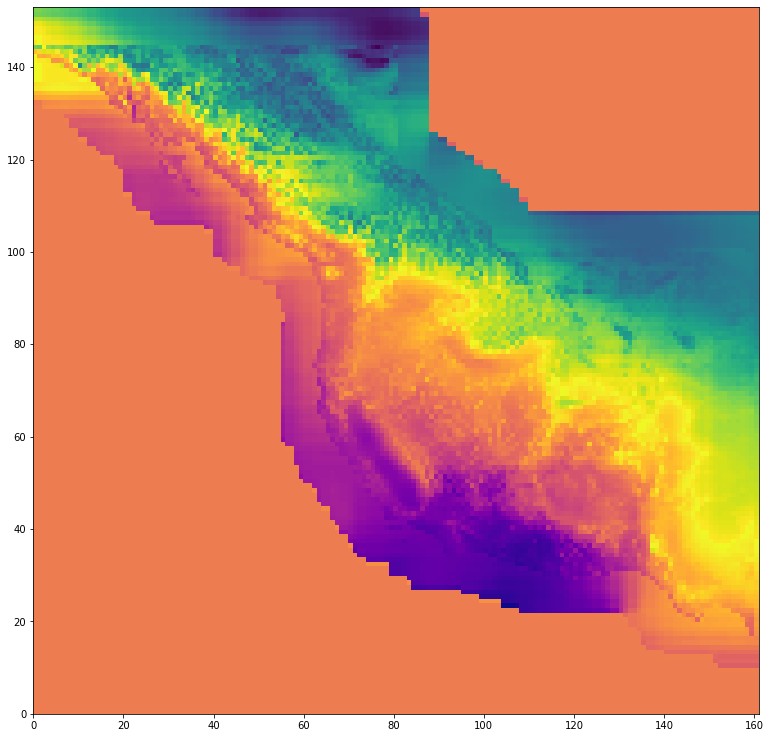

In [20]:
fig = plt.figure(figsize=(13, 13))
plt.pcolormesh(REGRID_2018[0, ...], cmap=camp_t2)

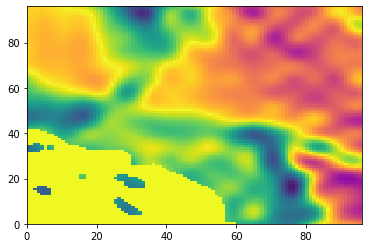

In [10]:
plt.pcolormesh(temp_data[()]['batch'][12, ..., 1], vmin=-3, vmax=3, cmap=camp_t2)

In [30]:
with h5py.File(PRISM_dir+'land_mask_NA.hdf', 'r') as hdf_io:
    lon_4km = hdf_io['lon_4km'][...]
    lat_4km = hdf_io['lat_4km'][...]
    lon_025 = hdf_io['lon_025'][...]
    lat_025 = hdf_io['lat_025'][...]

In [86]:
with h5py.File(JRA_dir+'JRA_TMEAN_clean_2019.hdf', 'r') as hio:
    test = hio['TMEAN_REGRID'][...]
    test_025 = hio['TMEAN_025'][...]
    
    

In [89]:
240*365/60/60

24.333333333333332

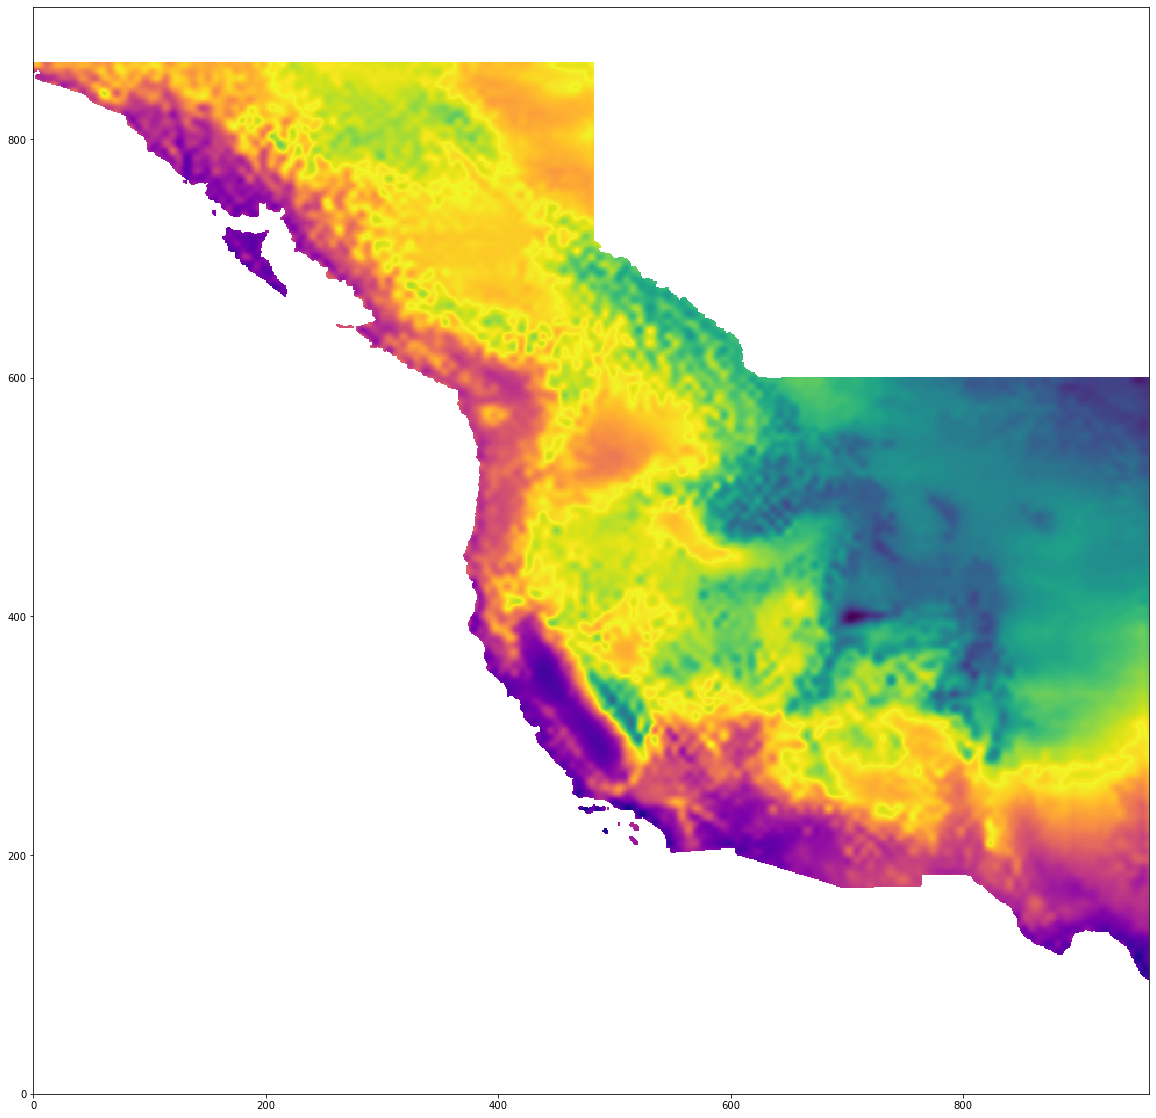

In [88]:
fig = plt.figure(figsize=(20, 20))
ax = fig.gca()
ax.pcolormesh(lon_4km, lat_4km, test[0, ...], cmap=camp_t2)


# UNet + Cycle-GAN test

In [24]:
model_import_dir = temp_dir
sea = 'djf'

In [25]:
unet0 = keras.models.load_model(model_import_dir+'UNET3_TMEAN_{}_tune.hdf'.format(sea))
unet1 = keras.models.load_model('/glade/work/ksha/data/Keras/BACKUP/UNET3_TMEAN_{}_clean.hdf'.format(sea))

In [26]:
# cgan1 = keras.models.load_model(model_import_dir+'Cycle-GAN_TMEAN_LR.hdf')
# cgan2 = keras.models.load_model(model_import_dir+'CNEW-GAN_TMEAN_LR.hdf')
# cgan3 = keras.models.load_model(model_import_dir+'CBACKUP-GAN_TMEAN_LR.hdf')
# cgan4 = keras.models.load_model(model_import_dir+'CGAN_TMEAN_LR.hdf')

In [27]:
input_flag = [False, True, True, True]
output_flag = [True, False, False, False]
labels = ['batch', 'batch']

file_path = BATCH_dir

valid_train = glob(file_path+'TMEAN_BATCH_*_VJRA-ORI_{}*'.format(sea))
valid_trans = glob(file_path+'TMEAN_BATCH_*_VJRA-SUB_{}*'.format(sea))
valid_train_clean = glob(file_path+'TMEAN_BATCH_*_VORI-JRA-clean_{}*'.format(sea))
valid_trans_clean = glob(file_path+'TMEAN_BATCH_*_VSUB-JRA-clean_{}*'.format(sea))

gen_train = tu.grid_grid_gen(valid_train, labels, input_flag, output_flag)
gen_trans = tu.grid_grid_gen(valid_trans, labels, input_flag, output_flag)
gen_train_clean = tu.grid_grid_gen(valid_train_clean, labels, input_flag, output_flag)
gen_trans_clean = tu.grid_grid_gen(valid_trans_clean, labels, input_flag, output_flag)

**jja**

In [57]:
print('JRA LR no CGAN')
unet0.evaluate_generator(gen_train, verbose=True)
unet0.evaluate_generator(gen_trans, verbose=True)

JRA LR no CGAN
13/13 [==============================] - 3s 236ms/step - loss: 1.2014 - mean_absolute_error: 1.0897


[1.2013634626681988, 1.0896695]

In [10]:
print('JRA LR with CGAN')
unet0.evaluate_generator(gen_train_clean, verbose=True)
unet0.evaluate_generator(gen_trans_clean, verbose=True)

JRA LR with CGAN
74/74 [==============================] - 12s 168ms/step - loss: 1.2046 - mean_absolute_error: 1.1173


[1.2045629064779024, 1.117282]

In [11]:
print('JRA LR with CGAN')
unet1.evaluate_generator(gen_train_clean, verbose=True)
unet1.evaluate_generator(gen_trans_clean, verbose=True)

JRA LR with CGAN
74/74 [==============================] - 13s 170ms/step - loss: 1.1895


1.1895122415310628

**DJF**

In [28]:
print('JRA LR no CGAN')
unet0.evaluate_generator(gen_train, verbose=True)
unet0.evaluate_generator(gen_trans, verbose=True)
print('JRA LR with CGAN')
unet0.evaluate_generator(gen_train_clean, verbose=True)
unet0.evaluate_generator(gen_trans_clean, verbose=True)

JRA LR no CGAN
13/13 [==============================] - 3s 199ms/step - loss: 1.2514 - mean_absolute_error: 1.1421
JRA LR with CGAN
73/73 [==============================] - 15s 206ms/step - loss: 1.3178 - mean_absolute_error: 1.2240


[1.3178161243869835, 1.2239822]

In [29]:
print('JRA LR with CGAN')
unet1.evaluate_generator(gen_train_clean, verbose=True)
unet1.evaluate_generator(gen_trans_clean, verbose=True)

JRA LR with CGAN
73/73 [==============================] - 14s 194ms/step - loss: 1.3341


1.3340754704932645

**Visualization**

In [12]:
prism_clean = glob(file_path+'TMEAN_BATCH_*_VORI-PRISM-clean_{}*'.format(sea))
temp_data = np.load(prism_clean[0], allow_pickle=True)[()]['batch']
plt.pcolormesh(temp_data[189, ..., 3], vmin=-3, vmax=3, cmap=camp_t2)

In [13]:
# UNet output

In [48]:
temp_data = np.load(valid_train[0], allow_pickle=True)[()]['batch']

In [49]:
out = unet0.predict([temp_data[..., input_flag]])

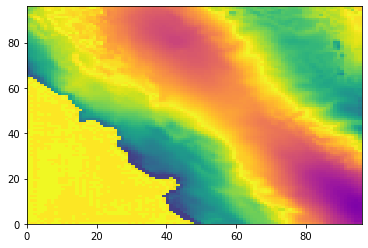

In [50]:
plt.pcolormesh(out[3, ..., 0], vmin=-3, vmax=3, cmap=camp_t2)

In [12]:
temp_data2 = np.load(valid_trans_clean[0], allow_pickle=True)[()]['batch']
out2 = unet1.predict([temp_data2[..., input_flag]])

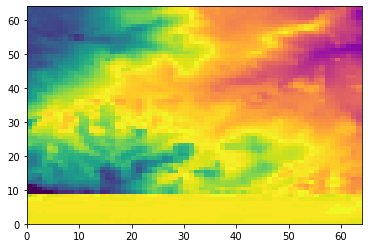

In [22]:
plt.pcolormesh(out2[160, ..., 0], vmin=-3, vmax=3, cmap=camp_t2)

In [14]:
temp_data2 = np.load(valid_trans_clean[0], allow_pickle=True)[()]['batch']
out3 = unet0.predict([temp_data2[..., input_flag]])

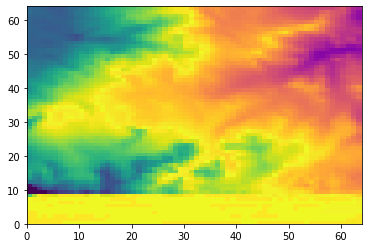

In [23]:
plt.pcolormesh(out3[160, ..., 0], vmin=-3, vmax=3, cmap=camp_t2)